In [1]:
library("deSolve")
library("ggplot2")

Warning message:
"package 'deSolve' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.2"

In [103]:
K_g = 1 # 0.7-1.2 confirmed
H_g = 250 # 1 was confirmed, but it was shit

K_gL = K_g/10
H_gL = H_g

e = 5e-7 # confirmed
K_d = 0.01
H_d = H_g

K_a = 2e-7 #2e-7 is confirmed
K_pd = 1e-9 #random number

B = 50 #confirmed

r = 1e-3 #1e-3 to 1e-5 confirmed

d = 0.00
lys_probs = c(0, 0.5, 0.60, 0.65, 0.70, 0.75)

In [118]:
# functions for ODE solving here

monod <- function(S, Ks){ # since it gets called a lot 
  return (S/(Ks+S))
}

p_kbinds <- function(lambda_G){
  NPs = c() # new phage binds sorted by bacterial MOI
  for(k in c(1:5)){
      NPs = append(NPs, dpois(k, lambda=lambda_G) )
  }
  NPs = append(NPs, ppois(6, lambda=lambda_G, lower=0))
  return(NPs)
}

f <- function(t, y, params){ # Main ODE system
  G = y[1]
  R = y[2]
  P = y[3]
  L = y[4]
  i = params[1]
  
  lambda_G = K_a * P

  N = K_g*G*monod(R,H_g)  
  NL = K_gL*L*monod(R,H_gL) 
  
  NPs = p_kbinds(lambda_G)
  N_kills = 0
  N_lys = 0
  for(index in seq_along(NPs)){
      N_kills = N_kills + NPs[index]*G*(1-lys_probs[index])
      N_lys = N_lys + NPs[index]*G*lys_probs[index]
  }
  
  dGdt = N - K_d*G*(1-monod(R, H_g)) - ppois(1, lambda=lambda_G, lower=0)*G - d*G #new bacterial growth - deaths - new phage binds
  dLdt = NL - K_d*L*(1-monod(R, H_g)) + N_lys - r*L - d*L #new lysogen growth + new lysogens - deaths - inductions  #- K_d*L*(1-monod(R, H_g))
  dRdt = -e*(N+NL) + i -d*R#depleted by new growth, add exogenous 
  dPdt =  B*N_kills + B*r*L - K_a*P*(G+0.01*L) - K_pd*P -d*P# lyses + inductions - new binds - phage deaths (supposed to be G+L)
  

  temp <- c(dGdt, dRdt, dPdt, dLdt)
  L = list(temp)
  
  return(list(temp))
}

In [119]:
# Playing with the model here. 
out = data.frame()

# Let the population grow to its normal equilibrium size
times <- seq(0,to=400,by=0.1)
initials <- c(G=1, R=100, P=1, L = 0)
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=10),times=times))
out <- rbind(out, out_1)

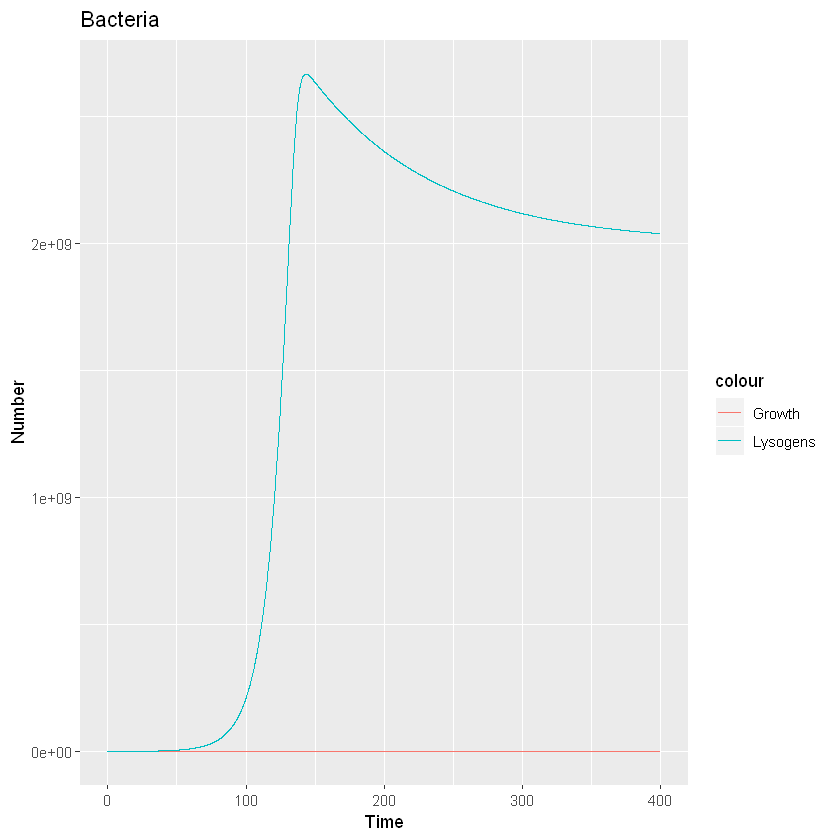

In [120]:
##### Plot our populations over time (I can't make a nice legend right now; RED is total bacteria, BLUE is stationary phase, GREEN is growth phase)
ggplot(out, aes(time))+geom_line(aes(y=G, color='Growth'))+geom_line(aes(y=L, color='Lysogens'))  + labs(title='Bacteria', x='Time', y='Number') 

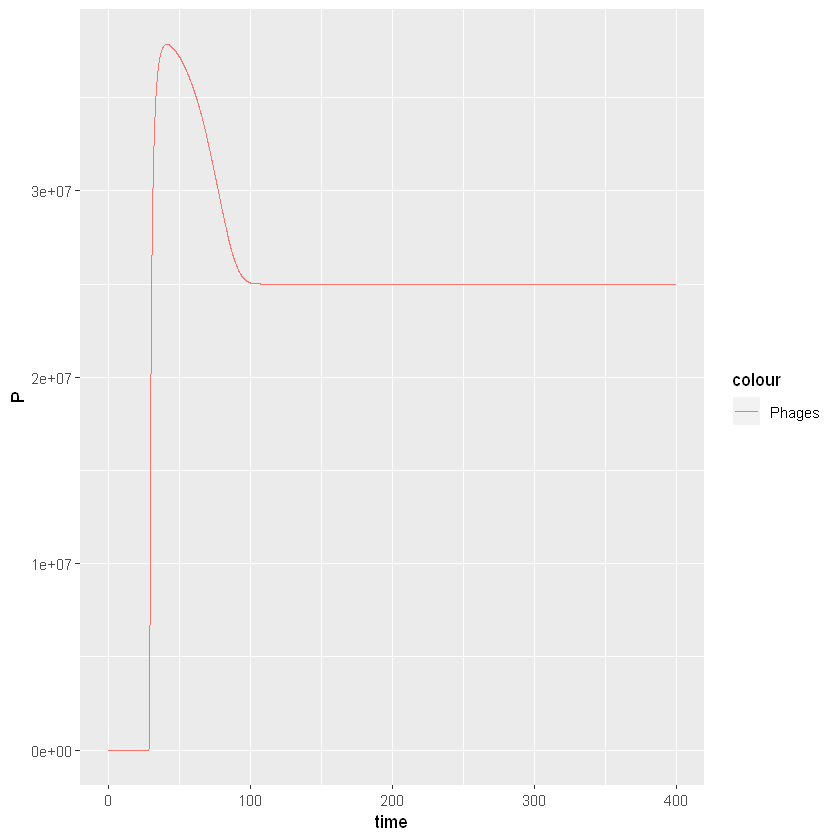

In [121]:
ggplot(out, aes(time))+geom_line(aes(y=P,color='Phages'))

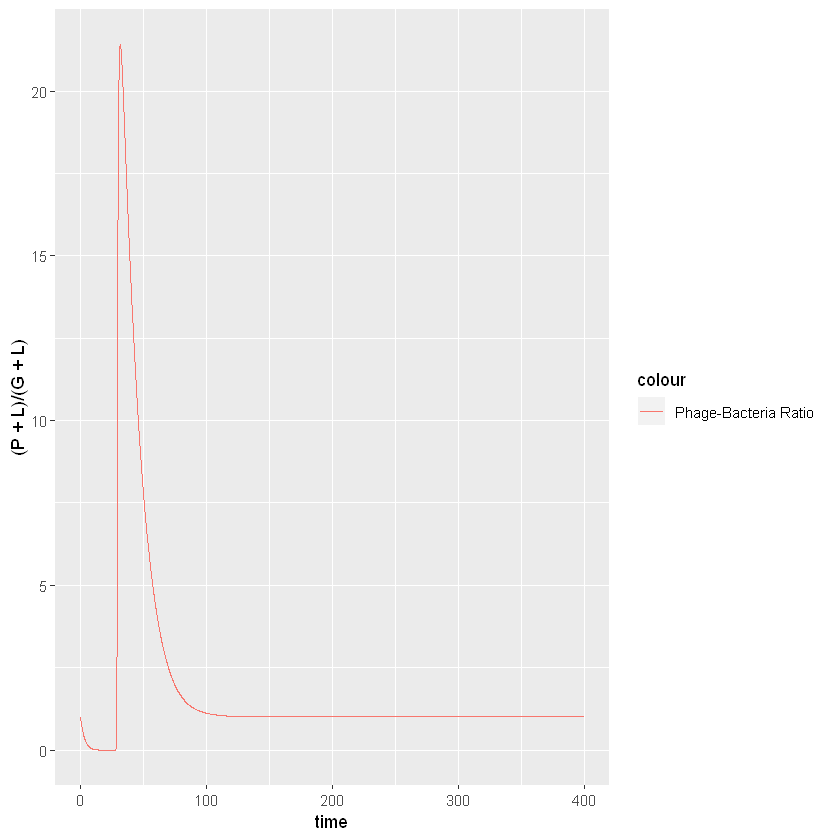

In [122]:
ggplot(out, aes(time))+geom_line(aes(y=(P+L)/(G+L),color='Phage-Bacteria Ratio'))

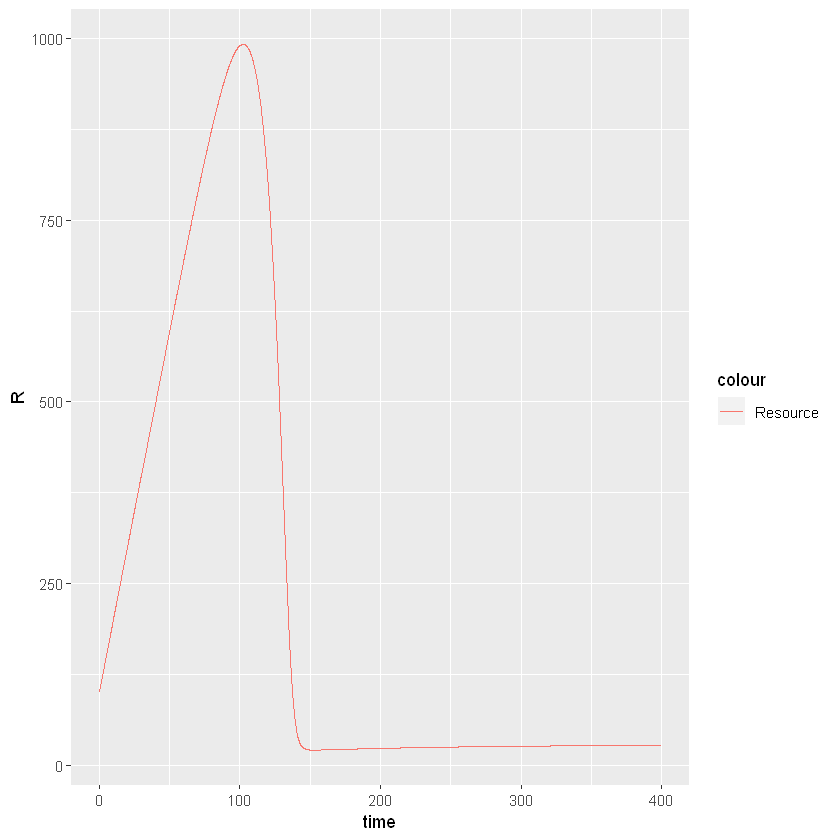

In [123]:
ggplot(out, aes(time))+geom_line(aes(y=R,color='Resource'))

In [124]:
z = c()
for (phage in out$P){
    NPs = p_kbinds(phage*K_a)
    total_infection_chance = sum(NPs)
    P_lys = 0
    for(index in seq_along(NPs)){
        P_lys = P_lys + NPs[index]*lys_probs[index]
    }
    
    z = append(z, P_lys/total_infection_chance)}

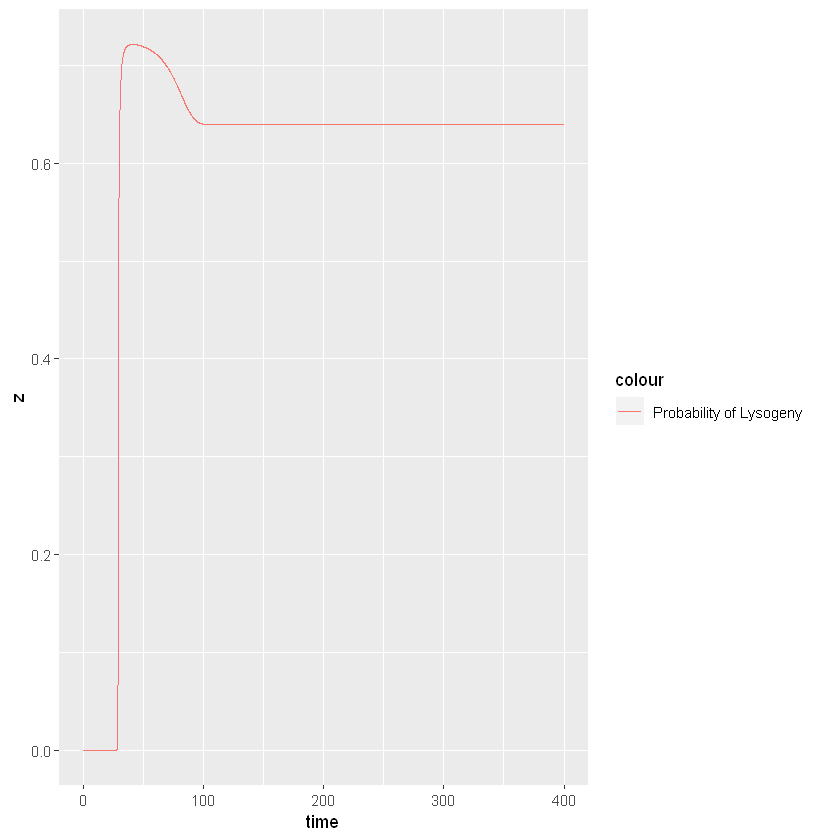

In [125]:
ggplot(out, aes(time))+ geom_line(aes(y=z,color='Probability of Lysogeny'))